In [1]:
import geopandas as gpd
import pandas as pd
import asf_search as asf
from shapely.geometry import Polygon, shape
import datetime
from tqdm import tqdm
from rasterio.crs import CRS
import warnings
from datetime import timezone
import matplotlib.pyplot as plt
from dswx_verification.val_db import get_localized_validation_table, get_classified_planet_table

# Read Validation Table

In [2]:
df_val = gpd.read_file('validation_table.geojson')
df_val.shape

(52, 15)

# 1. Get the SLC ID that covers validation site

In [3]:
def get_results_and_format(validation_footprint: Polygon, 
                           validation_date_acq: datetime.datetime,
                           planet_id: str,
                           window_days: int = 12):
    
    validation_date_acq = validation_date_acq.replace(tzinfo=timezone.utc)
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=validation_footprint.wkt,
                         maxResults=100,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=(validation_date_acq - datetime.timedelta(days=window_days)),
                         end=(validation_date_acq + datetime.timedelta(days=window_days))
                         )
    
    geometry = [shape(r.geojson()['geometry']) for r in res]
    data = [r.properties for r in res]

    df_res = pd.DataFrame(data)
    df_res = gpd.GeoDataFrame(df_res,
                              geometry=geometry,
                              crs=CRS.from_epsg(4326))
    if not df_res.empty:
        df_res['planet_id'] = planet_id
        df_res['startTime'] = pd.to_datetime(df_res['startTime'])
        
        df_res.sort_values(by=['pathNumber','startTime'], inplace=True)
        julian_dates = df_res.startTime.map(lambda dt: dt.to_julian_date())
        ## Note this calculus depends on the repeat pass frequency of Sentinel-1 which is 6
        df_res['repeat_pass_id'] = ((julian_dates - julian_dates[0]) // 5).astype(int)
        df_res = df_res.dissolve(by=['repeat_pass_id', 'pathNumber'], aggfunc='first').reset_index(drop=False)
        
        total_seconds = (df_res['startTime'] - validation_date_acq).dt.total_seconds()
        df_res['acq_delta_hours'] = total_seconds / (60**2)
        df_res['acq_delta_days'] = df_res['acq_delta_hours'] / 24
        df_res['acq_delta_hours_abs'] = df_res['acq_delta_hours'].abs()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            overlap_area = df_res['geometry'].intersection(validation_footprint).area
            df_res['overlap_percentage'] = (overlap_area / validation_footprint.area ) * 100
        df_res.sort_values(by=['acq_delta_hours_abs', 'overlap_percentage'], inplace=True)
        df_res = df_res.reset_index(drop=True)
    return df_res

## Multithreaded requests

In [4]:
import concurrent.futures

_, data_dicts = zip(*list(df_val.iterrows()))

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    dfs = list(tqdm(executor.map(lambda data: get_results_and_format(data['geometry'], 
                                                                     data['planet_acq_time'],
                                                                     data['planet_id']), 
                                 data_dicts), 
                    total=len(data_dicts)))

100%|███████████████| 52/52 [00:07<00:00,  6.84it/s]


In [5]:
dfs[0].columns

Index(['repeat_pass_id', 'pathNumber', 'geometry', 'centerLat', 'centerLon',
       'stopTime', 'fileID', 'flightDirection', 'processingLevel', 'url',
       'startTime', 'sceneName', 'browse', 'platform', 'bytes', 'md5sum',
       'frameNumber', 'granuleType', 'orbit', 'polarization', 'processingDate',
       'sensor', 'groupID', 'pgeVersion', 'fileName', 'beamModeType',
       'planet_id', 'acq_delta_hours', 'acq_delta_days', 'acq_delta_hours_abs',
       'overlap_percentage'],
      dtype='object')

In [6]:
df_s1 = pd.concat(dfs, axis=0).reset_index(drop=True)
df_s1.shape

(243, 31)

Include water stratum

In [7]:
df_s1_merged = pd.merge(df_val[['planet_id', 'water_stratum', 'mgrs_tile']], df_s1, on='planet_id', how='right')
print(df_s1_merged.shape)
df_s1_merged.head()

(243, 33)


,planet_id,water_stratum,mgrs_tile,repeat_pass_id,pathNumber,geometry,centerLat,centerLon,stopTime,fileID,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,acq_delta_hours,acq_delta_days,acq_delta_hours_abs,overlap_percentage
0,20210914_103644_25_2413,3.0,T32VMK,-3,139,"POLYGON ((11.73264 56.89549, 12.39452 58.49953...",57.9306,9.8869,2021-09-14T05:40:16.000Z,S1B_IW_SLC__1SDV_20210914T053949_20210914T0540...,...,2021-09-14T05:39:49.000Z,C-SAR,S1B_IWDV_0398_0405_028690_139,003.31,S1B_IW_SLC__1SDV_20210914T053949_20210914T0540...,IW,-4.948611,-0.206192,4.948611,100.000000
1,20210914_103644_25_2413,3.0,T32VMK,-3,44,"POLYGON ((7.38857 58.72607, 8.05488 57.12395, ...",58.1570,9.8990,2021-09-13T17:02:44.000Z,S1A_IW_SLC__1SDV_20210913T170217_20210913T1702...,...,2021-09-13T17:02:17.000Z,C-SAR,S1A_IWDV_0186_0193_039666_044,003.31,S1A_IW_SLC__1SDV_20210913T170217_20210913T1702...,IW,-17.574167,-0.732257,17.574167,100.000000
2,20210914_103644_25_2413,3.0,T32VMK,-3,37,"POLYGON ((10.11510 58.10732, 10.80897 59.70935...",59.1422,8.2297,2021-09-13T05:48:51.000Z,S1A_IW_SLC__1SDV_20210913T054824_20210913T0548...,...,2021-09-13T05:48:24.000Z,C-SAR,S1A_IWDV_0394_0401_039659_037,003.31,S1A_IW_SLC__1SDV_20210913T054824_20210913T0548...,IW,-28.805556,-1.200231,28.805556,100.000000
3,20210914_103644_25_2413,3.0,T32VMK,-3,117,"POLYGON ((4.91370 59.64262, 5.60713 58.04212, ...",59.0780,7.5014,2021-09-12T17:10:31.000Z,S1B_IW_SLC__1SDV_20210912T171004_20210912T1710...,...,2021-09-12T17:10:04.000Z,C-SAR,S1B_IWDV_0190_0196_028668_117,003.31,S1B_IW_SLC__1SDV_20210912T171004_20210912T1710...,IW,-41.444444,-1.726852,41.444444,100.000000
4,20210914_103644_25_2413,3.0,T32VMK,-3,110,"POLYGON ((7.95638 57.73010, 8.64183 59.33296, ...",58.7670,6.0717,2021-09-12T05:56:29.000Z,S1B_IW_SLC__1SDV_20210912T055602_20210912T0556...,...,2021-09-12T05:56:02.000Z,C-SAR,S1B_IWDV_0396_0402_028661_110,003.31,S1B_IW_SLC__1SDV_20210912T055602_20210912T0556...,IW,-52.678333,-2.194931,52.678333,50.915451


Remove small overlaps

In [8]:
MINIMUM_OVERLAP_THRESHOLD = 90
if True:
    ind = df_s1_merged['overlap_percentage'] > 90
    df_s1_merged = df_s1_merged[ind].reset_index(drop=True)

In [9]:
df_s1_merged.head()

,planet_id,water_stratum,mgrs_tile,repeat_pass_id,pathNumber,geometry,centerLat,centerLon,stopTime,fileID,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,acq_delta_hours,acq_delta_days,acq_delta_hours_abs,overlap_percentage
0,20210914_103644_25_2413,3.0,T32VMK,-3,139,"POLYGON ((11.73264 56.89549, 12.39452 58.49953...",57.9306,9.8869,2021-09-14T05:40:16.000Z,S1B_IW_SLC__1SDV_20210914T053949_20210914T0540...,...,2021-09-14T05:39:49.000Z,C-SAR,S1B_IWDV_0398_0405_028690_139,003.31,S1B_IW_SLC__1SDV_20210914T053949_20210914T0540...,IW,-4.948611,-0.206192,4.948611,100.0
1,20210914_103644_25_2413,3.0,T32VMK,-3,44,"POLYGON ((7.38857 58.72607, 8.05488 57.12395, ...",58.1570,9.8990,2021-09-13T17:02:44.000Z,S1A_IW_SLC__1SDV_20210913T170217_20210913T1702...,...,2021-09-13T17:02:17.000Z,C-SAR,S1A_IWDV_0186_0193_039666_044,003.31,S1A_IW_SLC__1SDV_20210913T170217_20210913T1702...,IW,-17.574167,-0.732257,17.574167,100.0
2,20210914_103644_25_2413,3.0,T32VMK,-3,37,"POLYGON ((10.11510 58.10732, 10.80897 59.70935...",59.1422,8.2297,2021-09-13T05:48:51.000Z,S1A_IW_SLC__1SDV_20210913T054824_20210913T0548...,...,2021-09-13T05:48:24.000Z,C-SAR,S1A_IWDV_0394_0401_039659_037,003.31,S1A_IW_SLC__1SDV_20210913T054824_20210913T0548...,IW,-28.805556,-1.200231,28.805556,100.0
3,20210914_103644_25_2413,3.0,T32VMK,-3,117,"POLYGON ((4.91370 59.64262, 5.60713 58.04212, ...",59.0780,7.5014,2021-09-12T17:10:31.000Z,S1B_IW_SLC__1SDV_20210912T171004_20210912T1710...,...,2021-09-12T17:10:04.000Z,C-SAR,S1B_IWDV_0190_0196_028668_117,003.31,S1B_IW_SLC__1SDV_20210912T171004_20210912T1710...,IW,-41.444444,-1.726852,41.444444,100.0
4,20210914_103644_25_2413,3.0,T32VMK,-2,117,"POLYGON ((5.24433 58.93230, 5.91616 57.33086, ...",58.3638,7.7658,2021-09-18T17:11:01.000Z,S1A_IW_SLC__1SDV_20210918T171034_20210918T1711...,...,2021-09-18T17:10:34.000Z,C-SAR,S1A_IWDV_0187_0194_039739_117,003.31,S1A_IW_SLC__1SDV_20210918T171034_20210918T1711...,IW,102.563889,4.273495,102.563889,100.0


In [10]:
df_s1_first = df_s1_merged.groupby(['planet_id'])[['acq_delta_days', 'mgrs_tile', 'overlap_percentage',  'pathNumber', 'fileID', 'water_stratum', 'startTime', 'geometry']].first()
df_s1_first = gpd.GeoDataFrame(df_s1_first, geometry=df_s1_first.geometry, crs=CRS.from_epsg(4326)).reset_index(drop=False)
df_s1_first.head()

,planet_id,acq_delta_days,mgrs_tile,overlap_percentage,pathNumber,fileID,water_stratum,startTime,geometry
0,20210903_150800_60_2458,-0.686875,T18UXG,100.0,62,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...,3.0,2021-09-02 22:38:54+00:00,"POLYGON ((-75.86066 56.10256, -75.25719 54.489..."
1,20210903_152641_60_105c,1.288623,T19UDA,100.0,91,S1A_IW_SLC__1SDV_20210904T222218_20210904T2222...,3.0,2021-09-04 22:22:18+00:00,"POLYGON ((-71.49984 55.57276, -70.91175 53.965..."
2,20210904_093422_44_1065,3.328356,T33JYG,100.0,131,S1A_IW_SLC__1SDV_20210907T172712_20210907T1727...,1.0,2021-09-07 17:27:12+00:00,"POLYGON ((16.88950 -29.53718, 17.36622 -31.148..."
3,20210906_101112_28_225a,0.321944,T30TYN,100.0,30,S1B_IW_SLC__1SDV_20210906T175448_20210906T1755...,2.0,2021-09-06 17:54:48+00:00,"POLYGON ((-1.78026 43.13633, -1.33798 41.46041..."
4,20210909_000649_94_222b,-0.168854,T54JTM,100.0,60,S1B_IW_SLC__1SDV_20210908T200340_20210908T2004...,1.0,2021-09-08 20:03:40+00:00,"POLYGON ((140.14239 -31.87752, 140.65891 -30.1..."


## Visualize

<Axes: >

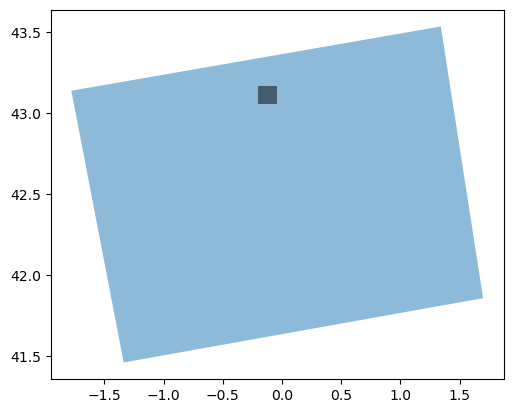

In [11]:
PLANET_ID = '20210906_101112_28_225a'

fig, ax = plt.subplots()

df_s1_first[df_s1_first.planet_id == PLANET_ID].plot(ax=ax, alpha=.5)
df_val[df_val.planet_id == PLANET_ID].plot(ax=ax, color='black', alpha=.5)

<Axes: >

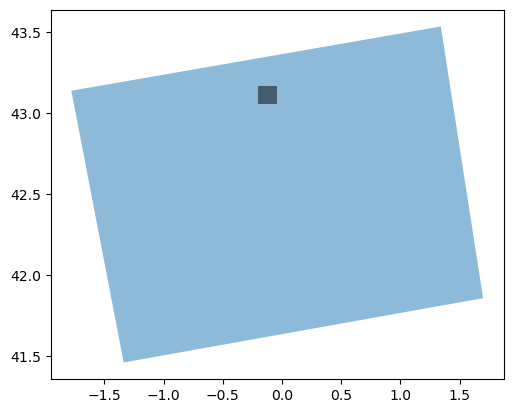

In [12]:
IMAGE_NAME = '20210928_141837_16_2407'

fig, ax = plt.subplots()

df_s1_first[df_s1_first.planet_id == PLANET_ID].plot(ax=ax, alpha=.5)
df_val[df_val.planet_id == PLANET_ID].plot(ax=ax, color='black', alpha=.5)

Shows histogram by water stratum.

array([[<Axes: title={'center': '0.0'}>, <Axes: title={'center': '1.0'}>],
       [<Axes: title={'center': '2.0'}>, <Axes: title={'center': '3.0'}>]],
      dtype=object)

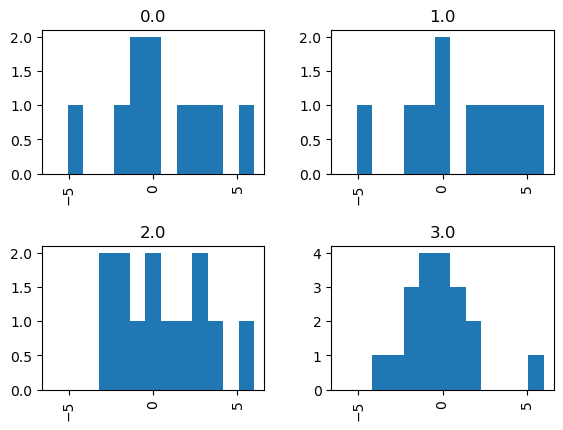

In [13]:
df_s1_first.hist('acq_delta_days', by='water_stratum', range=(-6, 6), bins=13)

Text(0, 0.5, '# of S1 Images (closest occuring)')

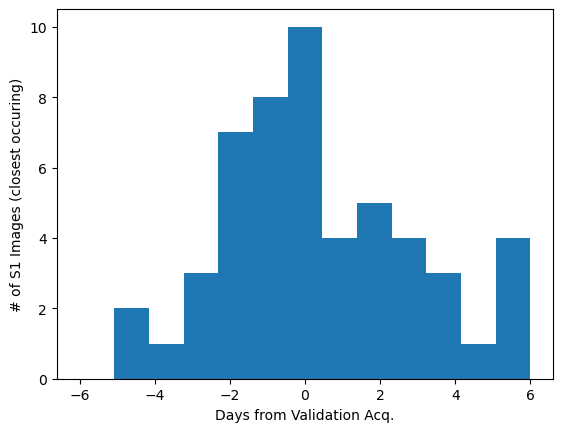

In [14]:
plt.hist(df_s1_first.acq_delta_days.values, range=(-6, 6), bins=13)
plt.xlabel('Days from Validation Acq.')
plt.ylabel('# of S1 Images (closest occuring)')

In [15]:
df_s1_first['overlap_percentage_r'] = df_s1_first.overlap_percentage.round()
df_s1_first.sort_values(by='overlap_percentage_r', inplace=True)
df_s1_first[['planet_id', 'overlap_percentage_r']].head()

,planet_id,overlap_percentage_r
0,20210903_150800_60_2458,100.0
28,20210930_070548_00_2442,100.0
29,20211002_155415_1009,100.0
30,20211003_161639_91_241d,100.0
31,20211004_132710_80_240c,100.0


In [16]:
df_s1_val_data = df_s1_first.reset_index(drop=True)
df_s1_val_data.head()

,planet_id,acq_delta_days,mgrs_tile,overlap_percentage,pathNumber,fileID,water_stratum,startTime,geometry,overlap_percentage_r
0,20210903_150800_60_2458,-0.686875,T18UXG,100.0,62,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...,3.0,2021-09-02 22:38:54+00:00,"POLYGON ((-75.86066 56.10256, -75.25719 54.489...",100.0
1,20210930_070548_00_2442,2.834363,T38TMT,100.0,152,S1A_IW_SLC__1SDV_20211003T030717_20211003T0307...,1.0,2021-10-03 03:07:17+00:00,"POLYGON ((47.07059 45.70861, 47.55445 47.38180...",100.0
2,20211002_155415_1009,0.281701,T18VVN,100.0,62,S1B_IW_SLC__1SDV_20211002T223954_20211002T2240...,3.0,2021-10-02 22:39:54+00:00,"POLYGON ((-78.35028 62.05849, -77.58303 60.461...",100.0
3,20211003_161639_91_241d,-1.664583,T14SQB,100.0,136,S1A_IW_SLC__1SDV_20211002T001939_20211002T0020...,2.0,2021-10-02 00:19:39+00:00,"POLYGON ((-96.17392 33.67741, -95.79823 32.047...",100.0
4,20211004_132710_80_240c,1.805000,T22KGE,100.0,24,S1A_IW_SLC__1SDV_20211006T084622_20211006T0846...,2.0,2021-10-06 08:46:22+00:00,"POLYGON ((-47.73277 -19.55300, -47.45538 -18.4...",100.0


# 2. Get all SLCs that cover an MGRS tile

In [17]:
from dem_stitcher.geojson_io import read_geojson_gzip, to_geojson_gzip

In [18]:
df_mgrs = read_geojson_gzip('s2_mgrs_grid.geojson.gzip')
df_mgrs.head()

,geometry,type,identifier
0,"MULTIPOLYGON Z (((180.00000 -73.05974 0.00000,...",S2,01CCV
1,"MULTIPOLYGON Z (((180.00000 -83.80855 0.00000,...",S2,01CDH
2,"MULTIPOLYGON Z (((180.00000 -82.91344 0.00000,...",S2,01CDJ
3,"MULTIPOLYGON Z (((180.00000 -82.01866 0.00000,...",S2,01CDK
4,"MULTIPOLYGON Z (((180.00000 -81.12317 0.00000,...",S2,01CDL


In [19]:
def lookup_mgrs_tile_geo(mgrs_tile_id: str) -> Polygon:
    df_tile = df_mgrs[df_mgrs.identifier == mgrs_tile_id].reset_index(drop=True)
    assert df_tile.shape[0] == 1, f'Found {df_tile.shape[0]} mgrs tiles'
    return df_tile

def get_slc_ids_to_cover_mgrs(row):
    # OPERA includes an extra T
    mgrs_tile_geo = lookup_mgrs_tile_geo(row['mgrs_tile'][1:]).geometry[0]

    start_time = pd.to_datetime(row['startTime'])
    
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=mgrs_tile_geo.wkt,
                         maxResults=100,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=(start_time - datetime.timedelta(days=1)),
                         end=(start_time + datetime.timedelta(days=1))
                         )
    
    data = [r.properties for r in res]
    slc_ids = [d['fileID'] for d in data]
    return ' '.join(slc_ids)

In [20]:
%%time

df_s1_val_data['slc_ids_to_cover_mgrs_tile'] = df_s1_val_data.apply(get_slc_ids_to_cover_mgrs, axis=1)

CPU times: user 1.75 s, sys: 39.1 ms, total: 1.79 s
Wall time: 24.8 s


In [21]:
df_s1_val_data.head()

,planet_id,acq_delta_days,mgrs_tile,overlap_percentage,pathNumber,fileID,water_stratum,startTime,geometry,overlap_percentage_r,slc_ids_to_cover_mgrs_tile
0,20210903_150800_60_2458,-0.686875,T18UXG,100.0,62,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...,3.0,2021-09-02 22:38:54+00:00,"POLYGON ((-75.86066 56.10256, -75.25719 54.489...",100.0,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...
1,20210930_070548_00_2442,2.834363,T38TMT,100.0,152,S1A_IW_SLC__1SDV_20211003T030717_20211003T0307...,1.0,2021-10-03 03:07:17+00:00,"POLYGON ((47.07059 45.70861, 47.55445 47.38180...",100.0,S1A_IW_SLC__1SDV_20211003T030717_20211003T0307...
2,20211002_155415_1009,0.281701,T18VVN,100.0,62,S1B_IW_SLC__1SDV_20211002T223954_20211002T2240...,3.0,2021-10-02 22:39:54+00:00,"POLYGON ((-78.35028 62.05849, -77.58303 60.461...",100.0,S1B_IW_SLC__1SDV_20211002T223954_20211002T2240...
3,20211003_161639_91_241d,-1.664583,T14SQB,100.0,136,S1A_IW_SLC__1SDV_20211002T001939_20211002T0020...,2.0,2021-10-02 00:19:39+00:00,"POLYGON ((-96.17392 33.67741, -95.79823 32.047...",100.0,S1A_IW_SLC__1SDV_20211002T001939_20211002T0020...
4,20211004_132710_80_240c,1.805000,T22KGE,100.0,24,S1A_IW_SLC__1SDV_20211006T084622_20211006T0846...,2.0,2021-10-06 08:46:22+00:00,"POLYGON ((-47.73277 -19.55300, -47.45538 -18.4...",100.0,S1B_IW_SLC__1SDV_20211007T083726_20211007T0837...


## 3. Find Burst IDs for MGRS Tile

In [22]:
df_all_bursts = read_geojson_gzip('opera_burst_ids.geojson.gzip')
df_all_bursts.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


In [23]:
df_all_bursts['track'] = df_all_bursts.burst_id_jpl.map(lambda bid: int(bid.split('_')[0][1:]))
df_all_bursts.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,track
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING,1
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING,1
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING,1
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING,1
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING,1


In [24]:
def get_bursts_df_that_cover_mgrs_tile(mgrs_tile_id: str, track: int) -> gpd.GeoDataFrame:
    # OPERA includes an extra T
    df_mgrs_tile = lookup_mgrs_tile_geo(mgrs_tile_id[1:])
    mgrs_tile_geo = df_mgrs_tile.geometry[0]
    xmin, ymin, xmax, ymax = mgrs_tile_geo.bounds
    df_burst_overlapping = df_all_bursts.cx[xmin: xmax, ymin: ymax]
    df_burst_overlapping = df_burst_overlapping[df_burst_overlapping.track == track].reset_index(drop=True)
    return df_burst_overlapping

def get_burst_ids_that_cover_mgrs_tile(mgrs_tile_id: str, track: int) -> str:
    df_bursts = get_bursts_df_that_cover_mgrs_tile(mgrs_tile_id, track)
    return ' '.join(df_bursts.burst_id_jpl.tolist())

Sanity check

<Axes: >

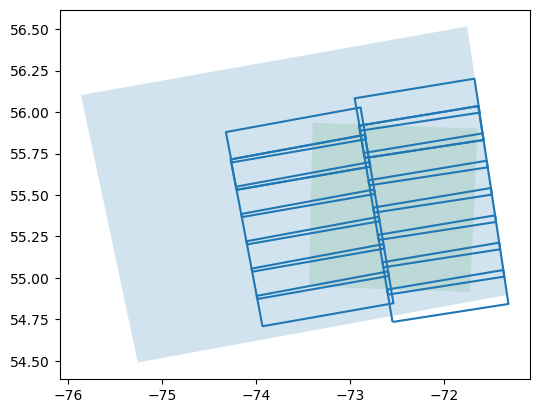

In [25]:
fig, ax = plt.subplots()

df_mgrs_tile = lookup_mgrs_tile_geo('18UXG')
df_bursts = get_bursts_df_that_cover_mgrs_tile('T18UXG', 62)
df_bursts.exterior.plot(ax=ax)
df_row = df_s1_val_data.iloc[:1]
df_row.plot(ax=ax, alpha=.2)
df_mgrs_tile.plot(alpha=.1, color='green', ax=ax)

In [26]:
mgrs_tiles = df_s1_val_data.mgrs_tile.tolist()
tracks = df_s1_val_data.pathNumber.tolist()

burst_ids_str = [get_burst_ids_that_cover_mgrs_tile(mid, track) for (mid, track) in zip(mgrs_tiles, tracks)]
df_s1_val_data['burst_ids'] = burst_ids_str

In [27]:
df_s1_val_data_f = df_s1_val_data.rename(columns={'pathNumber': 'track_number', 
                                                  'startTime': 'primary_slc_start_time',
                                                  'fileID': 'primary_slc_id'})
df_s1_val_data_f.head()

,planet_id,acq_delta_days,mgrs_tile,overlap_percentage,track_number,primary_slc_id,water_stratum,primary_slc_start_time,geometry,overlap_percentage_r,slc_ids_to_cover_mgrs_tile,burst_ids
0,20210903_150800_60_2458,-0.686875,T18UXG,100.0,62,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...,3.0,2021-09-02 22:38:54+00:00,"POLYGON ((-75.86066 56.10256, -75.25719 54.489...",100.0,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...,t062_131347_iw3 t062_131348_iw2 t062_131348_iw...
1,20210930_070548_00_2442,2.834363,T38TMT,100.0,152,S1A_IW_SLC__1SDV_20211003T030717_20211003T0307...,1.0,2021-10-03 03:07:17+00:00,"POLYGON ((47.07059 45.70861, 47.55445 47.38180...",100.0,S1A_IW_SLC__1SDV_20211003T030717_20211003T0307...,t152_325127_iw3 t152_325128_iw3 t152_325129_iw...
2,20211002_155415_1009,0.281701,T18VVN,100.0,62,S1B_IW_SLC__1SDV_20211002T223954_20211002T2240...,3.0,2021-10-02 22:39:54+00:00,"POLYGON ((-78.35028 62.05849, -77.58303 60.461...",100.0,S1B_IW_SLC__1SDV_20211002T223954_20211002T2240...,t062_131381_iw2 t062_131382_iw1 t062_131382_iw...
3,20211003_161639_91_241d,-1.664583,T14SQB,100.0,136,S1A_IW_SLC__1SDV_20211002T001939_20211002T0020...,2.0,2021-10-02 00:19:39+00:00,"POLYGON ((-96.17392 33.67741, -95.79823 32.047...",100.0,S1A_IW_SLC__1SDV_20211002T001939_20211002T0020...,t136_290160_iw1 t136_290161_iw1 t136_290161_iw...
4,20211004_132710_80_240c,1.805000,T22KGE,100.0,24,S1A_IW_SLC__1SDV_20211006T084622_20211006T0846...,2.0,2021-10-06 08:46:22+00:00,"POLYGON ((-47.73277 -19.55300, -47.45538 -18.4...",100.0,S1B_IW_SLC__1SDV_20211007T083726_20211007T0837...,t024_050588_iw1 t024_050588_iw2 t024_050589_iw...


In [28]:
df_s1_val_data_f.to_file('s1_ids_for_val.geojson', driver='GeoJSON')